# Optimization of Uncertainties


***

**Content**
1. Importing packages
2. Select outcomes of interest
3. Find worst case scenario for best policy
4. Find worst case scenario for worst policy

***

### 1 | Importing packages

Start with importing the packages that are needed to complete the open exlporation. This includes more general packages and more specific packages from, for instance, the EMA workbench.


In [19]:
# Importing the required packages
from ema_workbench import (Model, 
                           MultiprocessingEvaluator,
                           ScalarOutcome, 
                           IntegerParameter, 
                           optimize, 
                           Scenario, 
                           Policy)

from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation, sum_over
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import functools
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 2 | Select outcomes of interest
***

In [20]:
#Get dike_model with problem formulation 3 
model, planning_steps = get_model_for_problem_formulation(2)


In [21]:
model.outcomes.clear()
model.outcomes= [ScalarOutcome(name = 'Expected Number of Deaths', 
                              variable_name=['A.1_Expected Number of Deaths 0', 
                                             'A.1_Expected Number of Deaths 1', 
                                             'A.1_Expected Number of Deaths 2',                                
                                            
                                      
                                             'A.2_Expected Number of Deaths 0', 
                                             'A.2_Expected Number of Deaths 1', 
                                             'A.2_Expected Number of Deaths 2',                                
                                   
                                             'A.3_Expected Number of Deaths 0', 
                                             'A.3_Expected Number of Deaths 1', 
                                             'A.3_Expected Number of Deaths 2',                                
                                             
                                             'A.4_Expected Number of Deaths 0', 
                                             'A.4_Expected Number of Deaths 1', 
                                             'A.4_Expected Number of Deaths 2',                               
                                      
                                             'A.5_Expected Number of Deaths 0', 
                                             'A.5_Expected Number of Deaths 1', 
                                             'A.5_Expected Number of Deaths 2',                                
                                            ], 
                                    function=sum_over,
                                    kind= ScalarOutcome.MAXIMIZE),
                                      
                ScalarOutcome(name='Dike Investment Costs', 
                              variable_name=['A.1_Dike Investment Costs 0', 
                                             'A.1_Dike Investment Costs 1', 
                                             'A.1_Dike Investment Costs 2', 
                                    
                                             'A.2_Dike Investment Costs 0', 
                                             'A.2_Dike Investment Costs 1', 
                                             'A.2_Dike Investment Costs 2', 
                                   
                                             'A.3_Dike Investment Costs 0', 
                                             'A.3_Dike Investment Costs 1', 
                                             'A.3_Dike Investment Costs 2', 
                                
                                             'A.4_Dike Investment Costs 0', 
                                             'A.4_Dike Investment Costs 1', 
                                             'A.4_Dike Investment Costs 2', 
                             
                                             'A.5_Dike Investment Costs 0', 
                                             'A.5_Dike Investment Costs 1', 
                                             'A.5_Dike Investment Costs 2'], 
                                    function=sum_over,
                                    kind= ScalarOutcome.MAXIMIZE),
                ScalarOutcome(name='RfR Investment Costs', 
                              variable_name=['RfR Total Costs 0', 
                                             'RfR Total Costs 1', 
                                             'RfR Total Costs 2'], 
                              function=sum_over,
                              kind = ScalarOutcome.MAXIMIZE)
                             ]

### 3 | Find worst case scenario for best policy
***

In [16]:
# Import the csv file with the best levers as a dataframe
df = pd.read_csv('./Results/MOEA_PF2_Deaths_DIKEandRfR_Investements_Costs_Deaths_results_best_policy.csv', index_col=0)
df

sample = np.random.randint(1,len(df))
# Exclude the outcomes and select best policy
df = df.iloc[:-3,sample]
df
# Convert the dataframe to a dictionary
best_policy = df.to_dict()
# best_policy

In [11]:
# Define the reference policy with the best levers
ref_policy = Policy('ref_best_policy', **best_policy)

# Define settings for the optimization
convergence_metrics = [EpsilonProgress()]
epsilons = [0.01] * len(model.outcomes)
nfe = 10000

# Perform the optimization
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='uncertainties',
                                              epsilons=epsilons,
                                              convergence=convergence_metrics,
                                              reference=ref_policy)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 1000/10000 nfe
[MainProcess/INFO] generation 15: 1500/10000 nfe
[MainProcess/INFO] generation 20: 2000/10000 nfe
[MainProcess/INFO] generation 25: 2500/10000 nfe
[MainProcess/INFO] generation 30: 3000/10000 nfe
[MainProcess/INFO] generation 35: 3500/10000 nfe
[MainProcess/INFO] generation 40: 4000/10000 nfe
[MainProcess/INFO] generation 45: 4500/10000 nfe
[MainProcess/INFO] generation 50: 5000/10000 nfe
[MainProcess/INFO] generation 55: 5500/10000 nfe
[MainProcess/INFO] generation 60: 6000/10000 nfe
[MainProcess/INFO] generation 65: 6500/10000 nfe
[MainProcess/INFO] generation 70: 7000/10000 nfe
[MainProcess/INFO] generation 75: 7500/10000 nfe
[MainProcess/INFO] generation 80: 8000/10000 nfe
[MainProcess/INFO] generation 85: 8500/10000 nfe
[MainProcess/INFO] generation 90: 9000/10000 nfe
[MainProcess/INFO] generation 95: 9500/1000

In [12]:
# Save the transposed results dataframe as a csv file
results.T.to_csv('./Results/MOEA_results_worst_case_scenario_best_policy_eps0.01.csv')

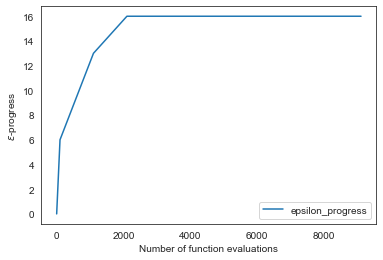

In [13]:
# Make and save the epsilon convergence plot
convergence.plot(x='nfe', y='epsilon_progress')
plt.ylabel('$\epsilon$-progress')
plt.xlabel('Number of function evaluations')
plt.savefig('./Results/MOEA_convergenceplot_wcs_best_policy_eps0.01.png', dpi=1000)

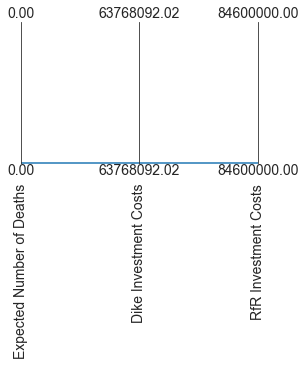

In [14]:
# Make and save the parallel coordinate plot
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.gcf().set_size_inches(4,8)
plt.savefig('./Results/MOEA_parallelcoordinateplot_wcs_best_policy_eps0.01.png', dpi=1000)

# Show the plots
plt.show()

### 4 | Find worst case scenario for worst policy
***

In [22]:
# Import the csv file with the best levers as a dataframe
df = pd.read_csv('./Results/MOEA_PF2_Deaths_DIKEandRfR_Investements_Costs_Deaths_results_worst_policy.csv', index_col=0)
df

sample = np.random.randint(1,len(df))
# Exclude the outcomes and select best policy
df = df.iloc[:-3,sample]
df
# Convert the dataframe to a dictionary
worst_policy = df.to_dict()
# best_policy

In [23]:
# Define the reference policy with the best levers
ref_policy = Policy('ref_best_policy', **worst_policy)

# Define settings for the optimization
convergence_metrics = [EpsilonProgress()]
epsilons = [0.01] * len(model.outcomes)
nfe = 10000

# Perform the optimization
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='uncertainties',
                                              epsilons=epsilons,
                                              convergence=convergence_metrics,
                                              reference=ref_policy)

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 1000/10000 nfe
[MainProcess/INFO] generation 15: 1500/10000 nfe
[MainProcess/INFO] generation 20: 2000/10000 nfe
[MainProcess/INFO] generation 25: 2500/10000 nfe
[MainProcess/INFO] generation 30: 3000/10000 nfe
[MainProcess/INFO] generation 35: 3500/10000 nfe
[MainProcess/INFO] generation 40: 4000/10000 nfe
[MainProcess/INFO] generation 45: 4500/10000 nfe
[MainProcess/INFO] generation 50: 5000/10000 nfe
[MainProcess/INFO] generation 55: 5500/10000 nfe
[MainProcess/INFO] generation 60: 6000/10000 nfe
[MainProcess/INFO] generation 65: 6500/10000 nfe
[MainProcess/INFO] generation 70: 7000/10000 nfe
[MainProcess/INFO] generation 75: 7500/10000 nfe
[MainProcess/INFO] generation 80: 8000/10000 nfe
[MainProcess/INFO] generation 85: 8500/10000 nfe
[MainProcess/INFO] generation 90: 9000/10000 nfe
[MainProcess/INFO] generation 95: 9500/10000 nfe
[MainProcess/INFO] optimiz

In [24]:
# Save the transposed results dataframe as a csv file
results.T.to_csv('./Results/MOEA_results_worst_case_scenario_worst_policy_eps0.01.csv')

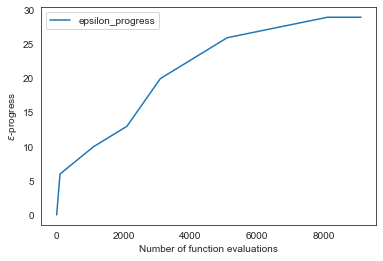

In [25]:
# Make and save the epsilon convergence plot
convergence.plot(x='nfe', y='epsilon_progress')
plt.ylabel('$\epsilon$-progress')
plt.xlabel('Number of function evaluations')
plt.savefig('./Results/MOEA_convergenceplot_wcs_best_policy_eps0.01.png', dpi=1000)

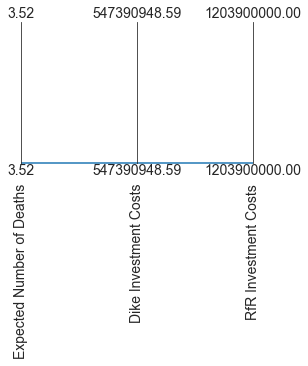

In [26]:
# Make and save the parallel coordinate plot
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.gcf().set_size_inches(4,8)
plt.savefig('./Results/MOEA_parallelcoordinateplot_wcs_best_policy_eps0.01.png', dpi=1000)

# Show the plots
plt.show()